# Gains FEM / PINNs+Corr

In [1]:
# sélection du cas test
testcase = 1
version = 2
n_params = 100
degree = 1

In [2]:
assert testcase == 1 and version in [1,2]
assert degree <= 3

## Imports + Load

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os
import dolfin as df
import seaborn as sns
import dataframe_image as dfi

from scimba.equations.domain import SpaceTensor
from scimba.equations import domain
from modfenics.solver_fem.solver_fem_1_1D import FEMSolver
from testcases.utils import create_tree
from modfenics.fenics_expressions.fenics_expressions_1D import UexExpr

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


Using device: cpu


/home/flecourtier/anaconda3/envs/phifem_scimba_2/lib/python3.9/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1702400441250/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [5]:
if version == 1:
    from testcases.networks.test_1D.test_1.test_1_v1 import Run_laplacian1D,Poisson_1D
elif version == 2:
    from testcases.networks.test_1D.test_1.test_1_v2 import Run_laplacian1D,Poisson_1D
from testcases.problem.problem_1D import TestCase1
problem = TestCase1()

result_dir = "../../results/test_1D/testcase"+str(testcase)+"/version"+str(version)
result_dir += "/facteurs/"
create_tree(result_dir)

tab_nb_vert = [20,40]
tab_h = []
for nb_vert in tab_nb_vert:
    solver = FEMSolver(nb_cell=nb_vert-1, params=[[]], problem=problem, degree=degree)
    tab_h.append(np.round(solver.mesh.hmax(),2))

/home/flecourtier/Bureau/Article1/code
torch loaded; device is cpu
hmax =  0.052631578947368474
hmax =  0.02564102564102566


init
Training PINN
init
>> load network /home/flecourtier/Bureau/Article1/code/networks/test_1D/test_fe1_v2.pth
network loaded
Error  tensor([0.0124])


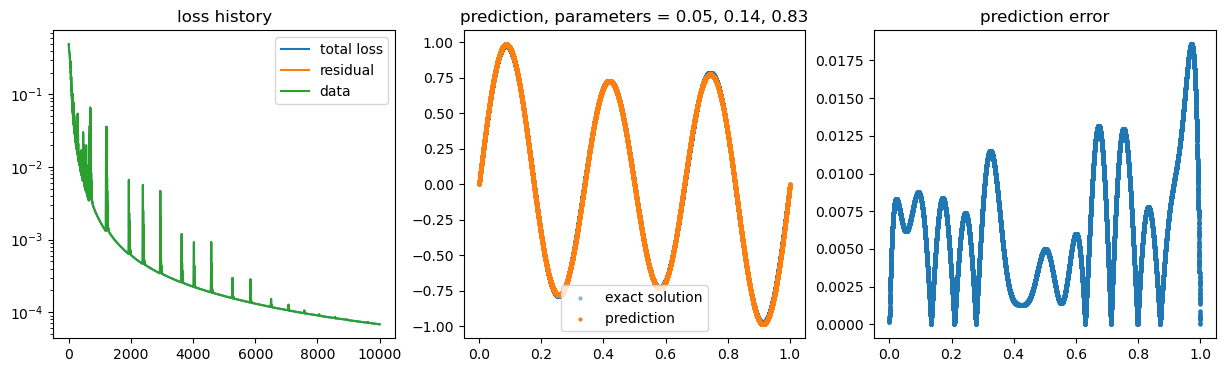

In [6]:
pde = Poisson_1D()
trainer,u_theta = Run_laplacian1D(pde)

In [7]:
def get_params(n_params):
    parameter_domain = trainer.pde.parameter_domain.cpu().numpy()
    # pick 1 random parameter
    np.random.seed(0)
    params = []
    for j in range(n_params):
        param = []
        for k in range(len(parameter_domain)):
            param.append(np.random.uniform(parameter_domain[k][0], parameter_domain[k][1]))
        params.append(param)
    # params = np.round(params, 2)
    return np.array(params)

params = get_params(n_params)
params_str = np.array([f"{params[i][0].round(2)},{params[i][1].round(2)},{params[i][2].round(2)}" for i in range(n_params)])

## Erreurs FEM

In [8]:
def read_csv_FEM(testcase,degree):
    df_FEM = pd.read_csv(result_dir+f'FEM_case{testcase}_degree{degree}.csv')
    tab_err_FEM = df_FEM.values[2:,1:]
    return tab_err_FEM

def run_FEM(degree,new_run=False):
    csv_file = result_dir+f'FEM_case{testcase}_degree{degree}.csv'
    col_names = [("FEM",str(tab_nb_vert[i]),tab_h[i]) for i in range(len(tab_nb_vert))]
    mi = pd.MultiIndex.from_tuples(col_names, names=["method","n_vert","h"])
        
    if not new_run and os.path.exists(csv_file):
        tab_err_FEM = read_csv_FEM(testcase,degree)
        df_FEM = pd.DataFrame(tab_err_FEM,columns=mi)
        print(f"Read csv file {csv_file}")
    else:
        tab_err_FEM = np.zeros((n_params,len(tab_nb_vert)))
        for (j,nb_vert) in enumerate(tab_nb_vert):
            print(f"nb_vert={nb_vert}")
            solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree)
            print("param =",end=" ")
            for i in range(n_params):
                print(i,end=" ")
                _,norme_L2 = solver.fem(i)
                tab_err_FEM[i,j] = norme_L2
            print()
        
        df_FEM = pd.DataFrame(tab_err_FEM,columns=mi)
        df_FEM.to_csv(csv_file)
           
    return df_FEM, tab_err_FEM

In [9]:
df_FEM, tab_err_FEM = run_FEM(degree)

nb_vert=20
hmax =  0.052631578947368474
param = 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 
nb_vert=40
hmax =  0.02564102564102566
param = 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 


## Erreur PINNs

In [10]:
def get_test_sample(i,solver,trainer,deg_PINNs):
    # get coordinates of the dof
    V_test = df.FunctionSpace(solver.mesh,"CG",deg_PINNs)
    XXYY = V_test.tabulate_dof_coordinates()
    X_test = torch.tensor(XXYY,requires_grad=True)
    X_test = SpaceTensor(X_test,torch.zeros_like(X_test,dtype=int))

    # get parameters
    nb_params = len(trainer.pde.parameter_domain)
    shape = (XXYY.shape[0],nb_params)
    ones = torch.ones(shape)
    mu_test = (torch.Tensor(params[i]).to(device) * ones).to(device)

    return V_test,X_test,mu_test

In [11]:
def read_csv_PINNs(testcase,degree):
    df_PINNs = pd.read_csv(result_dir+f'PINNs_case{testcase}_degree{degree}.csv')
    tab_err_PINNs = df_PINNs.values[2:,1:]
    
    return tab_err_PINNs

def run_PINNs(degree,new_run=False):
    csv_file = result_dir+f'PINNs_case{testcase}_degree{degree}.csv'
    col_names = [("PINNs",str(tab_nb_vert[i]),tab_h[i]) for i in range(len(tab_nb_vert))]
    mi = pd.MultiIndex.from_tuples(col_names, names=["method","n_vert","h"])
    if not new_run and os.path.exists(csv_file):
        tab_err_PINNs = read_csv_PINNs(testcase,degree)
        df_PINNs = pd.DataFrame(tab_err_PINNs,columns=mi)
        print(f"Read csv file {csv_file}")
    else:
        tab_err_PINNs = np.zeros((n_params,len(tab_nb_vert)))

        for (j,nb_vert) in enumerate(tab_nb_vert):
            print(f"nb_vert={nb_vert}")
            solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree)
            degree_PINNs = solver.high_degree
            print("param =",end=" ")
            for i in range(n_params):
                print(i,end=" ")
                V_test,X_test,mu_test = get_test_sample(i,solver,trainer,degree_PINNs)
                pred = u_theta.setup_w_dict(X_test, mu_test)
                phi_tild = pred["w"][:,0].cpu().detach().numpy()
                
                u_PINNs = df.Function(V_test)
                u_PINNs.vector()[:] = phi_tild.copy()
                
                param = params[i]
                u_ex = UexExpr(param, degree=degree_PINNs, domain=solver.mesh, pb_considered=problem)
                
                uref_Vex = df.interpolate(u_ex,solver.V_ex)
                norme_L2 = (df.assemble((((uref_Vex - u_PINNs)) ** 2) * solver.dx) ** (0.5)) / (df.assemble((((uref_Vex)) ** 2) * solver.dx) ** (0.5))
            
                tab_err_PINNs[i,j] = norme_L2
            print()

        
        df_PINNs = pd.DataFrame(tab_err_PINNs,columns=mi)
        df_PINNs.to_csv(csv_file)
        
    return df_PINNs, tab_err_PINNs

In [12]:
df_PINNs, tab_err_PINNs = run_PINNs(degree)

nb_vert=20
hmax =  0.052631578947368474
param = 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 
nb_vert=40
hmax =  0.02564102564102566
param = 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 


## Erreur Corr

In [13]:
degree_PINNs = 10

def read_csv_Corr_Add(testcase,degree):
    df_Corr = pd.read_csv(result_dir+f'Corr_case{testcase}_degree{degree}.csv')
    tab_err_Corr = df_Corr.values[2:,1:]
    return tab_err_Corr

def run_Corr_Add(degree,new_run=False):
    csv_file = result_dir+f'Corr_case{testcase}_degree{degree}.csv'
    col_names = [("Corr",str(tab_nb_vert[i]),tab_h[i]) for i in range(len(tab_nb_vert))]
    mi = pd.MultiIndex.from_tuples(col_names, names=["method","n_vert","h"])
        
    if not new_run and os.path.exists(csv_file):
        tab_err_Corr = read_csv_Corr_Add(testcase,degree)
        df_Corr = pd.DataFrame(tab_err_Corr,columns=mi)
        print(f"Read csv file {csv_file}")
    else:
        tab_err_Corr = np.zeros((n_params,len(tab_nb_vert)))
        for (j,nb_vert) in enumerate(tab_nb_vert):
            print(f"nb_vert={nb_vert}")
            solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree)
            print("param =",end=" ")
            for i in range(n_params):
                print(i,end=" ")
                
                V_test,X_test,mu_test = get_test_sample(i,solver,trainer,degree_PINNs)
                pred = u_theta.setup_w_dict(X_test, mu_test)
                phi_tild = pred["w"][:,0].cpu().detach().numpy()
                
                u_PINNs = df.Function(V_test)
                u_PINNs.vector()[:] = phi_tild.copy()
                
                _,_,norme_L2 = solver.corr_add(i,u_PINNs)
                tab_err_Corr[i,j] = norme_L2
            print()
        
        df_Corr = pd.DataFrame(tab_err_Corr,columns=mi)
        df_Corr.to_csv(csv_file)
           
    return df_Corr, tab_err_Corr

In [14]:
df_Corr, tab_err_Corr = run_Corr_Add(degree)

nb_vert=20
hmax =  0.052631578947368474
param = 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 
nb_vert=40
hmax =  0.02564102564102566
param = 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 


In [15]:
degree_PINNs = 10

def read_csv_Corr_Mult(testcase,degree,M):
    df_Mult = pd.read_csv(result_dir+f'Mult_case{testcase}_degree{degree}_M{M}.csv')
    tab_err_Mult = df_Mult.values[2:,1:]
    return tab_err_Mult

def run_Corr_Mult(degree,M=0.0,new_run=False):
    csv_file = result_dir+f'Mult_case{testcase}_degree{degree}_M{M}.csv'
    col_names = [("Mult",str(tab_nb_vert[i]),tab_h[i]) for i in range(len(tab_nb_vert))]
    mi = pd.MultiIndex.from_tuples(col_names, names=["method","n_vert","h"])
        
    if not new_run and os.path.exists(csv_file):
        tab_err_Mult = read_csv_Corr_Mult(testcase,degree,M)
        df_Mult = pd.DataFrame(tab_err_Mult,columns=mi)
        print(f"Read csv file {csv_file}")
    else:
        tab_err_Mult = np.zeros((n_params,len(tab_nb_vert)))
        for (j,nb_vert) in enumerate(tab_nb_vert):
            print(f"nb_vert={nb_vert}")
            solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree)
            print("param =",end=" ")
            for i in range(n_params):
                print(i,end=" ")
                
                V_test,X_test,mu_test = get_test_sample(i,solver,trainer,degree_PINNs)
                pred = u_theta.setup_w_dict(X_test, mu_test)
                phi_tild = pred["w"][:,0].cpu().detach().numpy()
                
                u_PINNs = df.Function(V_test)
                u_PINNs.vector()[:] = phi_tild.copy()
                
                _,_,norme_L2 = solver.corr_mult(i,u_PINNs,M)
                tab_err_Mult[i,j] = norme_L2
            print()
        
        df_Mult = pd.DataFrame(tab_err_Mult,columns=mi)
        df_Mult.to_csv(csv_file)
           
    return df_Mult, tab_err_Mult

In [16]:
M = 3.0
df_Mult3, tab_err_Mult3 = run_Corr_Mult(degree,M=M)

nb_vert=20
hmax =  0.052631578947368474
param = 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 
nb_vert=40
hmax =  0.02564102564102566
param = 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 


In [17]:
M = 100.0
df_Mult100, tab_err_Mult100 = run_Corr_Mult(degree,M=M)

nb_vert=20
hmax =  0.052631578947368474
param = 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 
nb_vert=40
hmax =  0.02564102564102566
param = 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 


## Dataframe erreurs

In [18]:
# concatenate dataframe : for each columns, we have the error for each method
# we want a multiindex dataframe with FEM, PINNs and Corr for each n_vert and h
col_names = [("FEM",str(tab_nb_vert[i]),str(tab_h[i])) for i in range(len(tab_nb_vert))] + \
        [("PINNs",str(tab_nb_vert[i]),str(tab_h[i])) for i in range(len(tab_nb_vert))] + \
        [("Add",str(tab_nb_vert[i]),str(tab_h[i])) for i in range(len(tab_nb_vert))] + \
        [("Mult3",str(tab_nb_vert[i]),str(tab_h[i])) for i in range(len(tab_nb_vert))] + \
        [("Mult100",str(tab_nb_vert[i]),str(tab_h[i])) for i in range(len(tab_nb_vert))]

mi = pd.MultiIndex.from_tuples(col_names, names=["method","n_vert","h"])
row_names = [str(i) + " : " + params_str[i] for i in range(n_params)]
df = pd.DataFrame(columns=mi,index=row_names)

for i in range(n_params):
    for j in range(len(tab_nb_vert)):
        df.loc[row_names[i],col_names[j]] = tab_err_FEM[i,j]
        j2=j+1
    for j in range(len(tab_nb_vert)):
        df.loc[row_names[i],col_names[j2+j]] = tab_err_PINNs[i,j]
        j3 = j2+j+1
    for j in range(len(tab_nb_vert)):
        df.loc[row_names[i],col_names[j3+j]] = tab_err_Corr[i,j]
        j4 = j3+j+1
    for j in range(len(tab_nb_vert)):
        df.loc[row_names[i],col_names[j4+j]] = tab_err_Mult3[i,j]
        j5 = j4+j+1
    for j in range(len(tab_nb_vert)):
        df.loc[row_names[i],col_names[j5+j]] = tab_err_Mult100[i,j]
        
        
df.to_csv(result_dir+f'comparison_case{testcase}_degree{degree}.csv')

## Dataframe facteurs

In [19]:
facteurs_FEM_PINNs = df["FEM"] / df["PINNs"]

facteurs_PINNs_Add = df["PINNs"] / df["Add"]
facteurs_PINNs_Mult3 = df["PINNs"] / df["Mult3"]
facteurs_PINNs_Mult100 = df["PINNs"] / df["Mult100"]

facteurs_FEM_Add = df["FEM"] / df["Add"]
facteurs_FEM_Mult3 = df["FEM"] / df["Mult3"]
facteurs_FEM_Mult100 = df["FEM"] / df["Mult100"]

col_names = [("FEM/PINNs",str(tab_nb_vert[i]),str(tab_h[i].round(2))) for i in range(len(tab_nb_vert))] + \
        [("PINNs/Add",str(tab_nb_vert[i]),str(tab_h[i].round(2))) for i in range(len(tab_nb_vert))] + \
        [("FEM/Add",str(tab_nb_vert[i]),str(tab_h[i].round(2))) for i in range(len(tab_nb_vert))] + \
        [("PINNs/Mult3",str(tab_nb_vert[i]),str(tab_h[i].round(2))) for i in range(len(tab_nb_vert))] + \
        [("FEM/Mult3",str(tab_nb_vert[i]),str(tab_h[i].round(2))) for i in range(len(tab_nb_vert))] + \
        [("PINNs/Mult100",str(tab_nb_vert[i]),str(tab_h[i].round(2))) for i in range(len(tab_nb_vert))] + \
        [("FEM/Mult100",str(tab_nb_vert[i]),str(tab_h[i].round(2))) for i in range(len(tab_nb_vert))]
mi = pd.MultiIndex.from_tuples(col_names, names=["facteurs","n_vert","h"])

index_names = [str(i) + " : " + params_str[i] for i in range(n_params)]
df_facteurs = pd.DataFrame(columns=mi,index=index_names)

for i in range(n_params):
    for j in range(len(tab_nb_vert)):
        df_facteurs.loc[index_names[i],col_names[j]] = facteurs_FEM_PINNs.to_numpy()[i,j]
        j2=j+1
    for j in range(len(tab_nb_vert)):
        df_facteurs.loc[index_names[i],col_names[j2+j]] = facteurs_PINNs_Add.to_numpy()[i,j]
        j3 = j2+j+1
    for j in range(len(tab_nb_vert)):
        df_facteurs.loc[index_names[i],col_names[j3+j]] = facteurs_FEM_Add.to_numpy()[i,j]
        j4 = j3+j+1
    for j in range(len(tab_nb_vert)):
        df_facteurs.loc[index_names[i],col_names[j4+j]] = facteurs_PINNs_Mult3.to_numpy()[i,j]
        j5 = j4+j+1
    for j in range(len(tab_nb_vert)):
        df_facteurs.loc[index_names[i],col_names[j5+j]] = facteurs_FEM_Mult3.to_numpy()[i,j]
        j6 = j5+j+1
    for j in range(len(tab_nb_vert)):
        df_facteurs.loc[index_names[i],col_names[j6+j]] = facteurs_PINNs_Mult100.to_numpy()[i,j]
        j7 = j6+j+1
    for j in range(len(tab_nb_vert)):
        df_facteurs.loc[index_names[i],col_names[j7+j]] = facteurs_FEM_Mult100.to_numpy()[i,j]
        
df_facteurs.to_csv(result_dir+f'comparison_facteurs_case{testcase}_degree{degree}.csv')


## Boxplots

In [20]:
sns.set_style('darkgrid')
sns.set_theme(style="ticks")
sns.set_context("paper")
    
def plot_boxplot(i):
    n_vert = tab_nb_vert[i]
    
    # on crée une dataframe contenant les facteurs pour chaque méthode avec n_vert=n_vert
    df_facteurs_n_vert = df_facteurs[[col for col in df_facteurs.columns if col[1] == str(n_vert)]]
    # on supprime la première colonne 
    df_facteurs_n_vert = df_facteurs_n_vert.drop(columns=[df_facteurs_n_vert.columns[0]])
    
    # on change les noms des colonnes
    df_facteurs_n_vert.columns = [col[0] for col in df_facteurs_n_vert.columns]

    sns.boxplot(data=df_facteurs_n_vert, orient="h", palette="Set2")
    plt.grid(axis="x", visible=True, which="both")
    plt.title(f"n_vert={n_vert}, n_params={n_params}")
    
    return df_facteurs_n_vert

def plot_table(df_facteurs_n_vert,ax):
    df_min = df_facteurs_n_vert.min(axis=0)
    df_max = df_facteurs_n_vert.max(axis=0)
    df_mean = df_facteurs_n_vert.mean(axis=0)
    
    df_val = pd.concat([df_min,df_max,df_mean],axis=1).T
    tab = df_val.values.T.astype(float)
    tab = np.round(tab,2)

    thetable = ax.table(cellText=tab, rowLabels=df_facteurs_n_vert.columns, colLabels=["min","max","mean"], loc='right', cellLoc='center', colLoc='center', bbox=[0,0,1,1])
    thetable.scale(1.,0.8)
    thetable.auto_set_font_size(False)
    
    ax.axis('off')

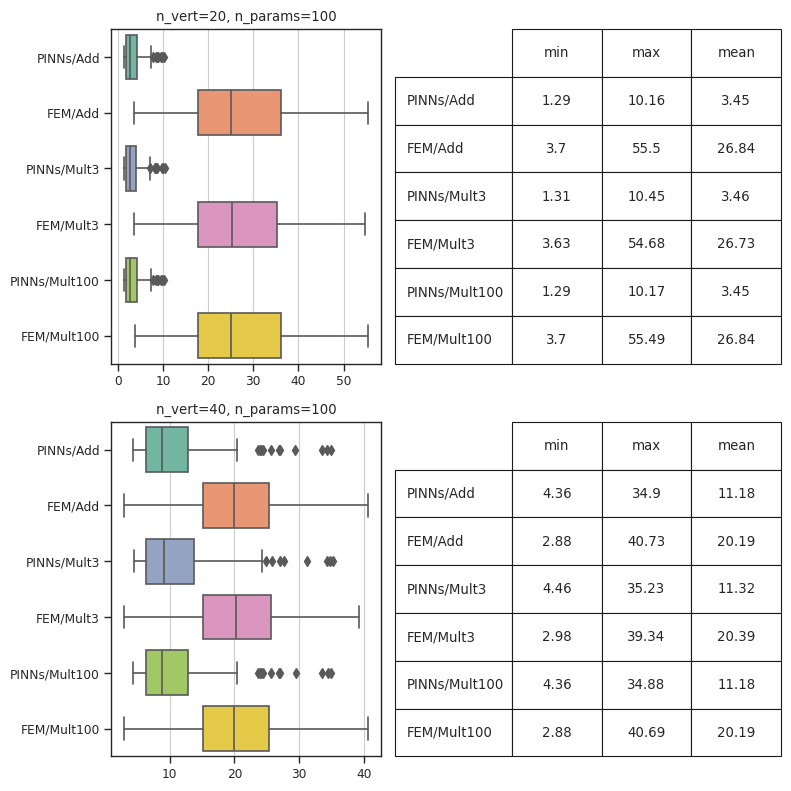

In [21]:
nb_test = len(tab_nb_vert)

plt.figure(figsize=(8,nb_test*4))

for i in range(nb_test):
    plt.subplot(nb_test,2,2*i+1)
    df_facteurs_n_vert = plot_boxplot(i)

    ax = plt.subplot(nb_test,2,2*i+2)
    plot_table(df_facteurs_n_vert,ax)

plt.tight_layout()
plt.savefig(result_dir+f'boxplot_facteurs_case{testcase}_degree{degree}.png')
plt.show()

## Table

In [22]:
df_min = df_facteurs_n_vert.min(axis=0)

df_min

PINNs/Add        4.360299
FEM/Add          2.879421
PINNs/Mult3      4.455091
FEM/Mult3        2.976693
PINNs/Mult100    4.362348
FEM/Mult100        2.8812
dtype: object

In [23]:
def get_df_facteurs_n_vert(i):
    n_vert = tab_nb_vert[i]
    
    # on crée une dataframe contenant les facteurs pour chaque méthode avec n_vert=n_vert
    df_facteurs_n_vert = df_facteurs[[col for col in df_facteurs.columns if col[1] == str(n_vert)]]
    # on supprime la première colonne 
    df_facteurs_n_vert = df_facteurs_n_vert.drop(columns=[df_facteurs_n_vert.columns[0]])
    
    # on change les noms des colonnes
    df_facteurs_n_vert.columns = [col[0] for col in df_facteurs_n_vert.columns]
    
    return df_facteurs_n_vert

def get_values(df_facteurs_n_vert):
    df_min = df_facteurs_n_vert.min(axis=0)
    df_max = df_facteurs_n_vert.max(axis=0)
    df_mean = df_facteurs_n_vert.mean(axis=0)
    df_std = df_facteurs_n_vert.std(axis=0)
        
    return [df_min["PINNs/Add"],df_max["PINNs/Add"],df_mean["PINNs/Add"],df_std["PINNs/Add"]], \
            [df_min["FEM/Add"],df_max["FEM/Add"],df_mean["FEM/Add"],df_std["FEM/Add"]], \
            [df_min["PINNs/Mult3"],df_max["PINNs/Mult3"],df_mean["PINNs/Mult3"],df_std["PINNs/Mult3"]], \
            [df_min["FEM/Mult3"],df_max["FEM/Mult3"],df_mean["FEM/Mult3"],df_std["FEM/Mult3"]], \
            [df_min["PINNs/Mult100"],df_max["PINNs/Mult100"],df_mean["PINNs/Mult100"],df_std["PINNs/Mult100"]], \
            [df_min["FEM/Mult100"],df_max["FEM/Mult100"],df_mean["FEM/Mult100"],df_std["FEM/Mult100"]]

In [24]:
nb_test = len(tab_nb_vert)

tab_gains_Add_on_PINNs,tab_gains_Mult3_on_PINNs,tab_gains_Mult100_on_PINNs = [],[],[]
tab_gains_Add_on_FEM,tab_gains_Mult3_on_FEM,tab_gains_Mult100_on_FEM = [],[],[]

for i in range(nb_test):
    df_facteurs_n_vert = get_df_facteurs_n_vert(i)
    gains_Add_on_PINNs,gains_Add_on_FEM,gains_Mult3_on_PINNs,gains_Mult3_on_FEM,gains_Mult100_on_PINNs,gains_Mult100_on_FEM = get_values(df_facteurs_n_vert)
    tab_gains_Add_on_PINNs.append(gains_Add_on_PINNs)
    tab_gains_Add_on_FEM.append(gains_Add_on_FEM)
    tab_gains_Mult3_on_PINNs.append(gains_Mult3_on_PINNs)
    tab_gains_Mult3_on_FEM.append(gains_Mult3_on_FEM)
    tab_gains_Mult100_on_PINNs.append(gains_Mult100_on_PINNs)
    tab_gains_Mult100_on_FEM.append(gains_Mult100_on_FEM)
    
tab_gains_Add_on_PINNs = np.array(tab_gains_Add_on_PINNs)
tab_gains_Add_on_FEM = np.array(tab_gains_Add_on_FEM)
tab_gains_Mult3_on_PINNs = np.array(tab_gains_Mult3_on_PINNs)
tab_gains_Mult3_on_FEM = np.array(tab_gains_Mult3_on_FEM)
tab_gains_Mult100_on_PINNs = np.array(tab_gains_Mult100_on_PINNs)
tab_gains_Mult100_on_FEM = np.array(tab_gains_Mult100_on_FEM)

columns= ["min_PINNs","max_PINNs","mean_PINNs","std_PINNs","min_FEM","max_FEM","mean_FEM","std_FEM"]

df_gains_Add = pd.DataFrame(np.concatenate([tab_gains_Add_on_PINNs,tab_gains_Add_on_FEM],axis=1),columns=columns,index=tab_nb_vert)
df_gains_Add.index.name = "N"
df_gains_Mult3 = pd.DataFrame(np.concatenate([tab_gains_Mult3_on_PINNs,tab_gains_Mult3_on_FEM],axis=1),columns=columns,index=tab_nb_vert)
df_gains_Mult3.index.name = "N"
df_gains_Mult100 = pd.DataFrame(np.concatenate([tab_gains_Mult100_on_PINNs,tab_gains_Mult100_on_FEM],axis=1),columns=columns,index=tab_nb_vert)
df_gains_Mult100.index.name = "N"

In [25]:
df_gains = pd.concat([df_gains_Add,df_gains_Mult3,df_gains_Mult100],keys=["Add","Mult3","Mult100"],names=["method"])
df_gains

min_PINNs  max_PINNs  mean_PINNs  std_PINNs   min_FEM    max_FEM  \
method  N                                                                      
Add     20   1.292499  10.161956    3.452468   2.101543  3.695119  55.498615   
        40   4.360299  34.896502   11.178449   7.073013  2.879421  40.725289   
Mult3   20   1.310109  10.453758    3.461548   2.109440  3.625512  54.682892   
        40   4.455091  35.230388   11.324930   7.150671  2.976693  39.336753   
Mult100 20   1.293058  10.170219    3.452850   2.102263  3.698876  55.486487   
        40   4.362348  34.881439   11.182802   7.075633  2.881200  40.692276   

             mean_FEM    std_FEM  
method  N                         
Add     20  26.844334  12.521415  
        40  20.185135   7.856406  
Mult3   20  26.733777  12.143465  
        40  20.391766   7.704334  
Mult100 20  26.843324  12.514066  
        40  20.191669   7.853643

In [26]:
result_file = result_dir+f'gains_table_case{testcase}_degree{degree}'

df_gains.to_csv(result_file+'.csv')
df_gains_round = df_gains.round(1)
# df_gains_round = df_gains_round.astype(int)

dfi.export(df_gains_round,result_file+".png",dpi=1000)